### Configuración de librerías

In [1]:
# Manejo de dataset y cálculos numéricos
import pandas as pd
import requests
import json
import numpy as np
import time
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ml_amazon")

# Redes neuronales
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

print(tf.version.VERSION)

2.5.0


### Variables

In [2]:
# Variable a predecir en la regresión
var = "PRICE"

# Para eliminar outliers entonces > outliers = False
outliers = False

# Porcentaje de división de datos para el entrenamiento
per = 70

# False si no queremos añadir variable de vacaciones
setHolidays = True

# Añadir early stop
early_stp = True

# Guardar modelo
save_model = True
checkpoint_path = "price_training/cp.ckpt"

# Cargar modelo para realizar predicciones
load_model = False
checkpoint_path_trained = "price_training/cp.ckpt" # Ruta del modelo entrenado

### Funciones auxiliares

In [3]:
def set_holidays(df_h):
    date_orders = df_h['DATE']
    date_orders
    
    i=0
    for date in date_orders:
        # Navidad > 1
        if (dat_nav_2018_ini < date < dat_nav_2018_fin) | (dat_nav_2019_ini < date < dat_nav_2019_fin) | (dat_nav_2020_ini < date < dat_nav_2020_fin):
            df_h.loc[i,'HOLIDAY'] = 1
        # Semana Santa > 2
        elif (dat_sn_2019_ini < date < dat_sn_2019_fin) | (dat_sn_2020_ini < date < dat_sn_2020_fin) | (dat_sn_2021_ini < date < dat_sn_2021_fin):
            df_h.loc[i,'HOLIDAY'] = 2
        # Black Friday > 3
        elif (date == dat_bf_2019) | (date == dat_bf_2020) | (date == dat_bf_2021) :
            df_h.loc[i,'HOLIDAY'] = 3
        # Prime Day > 4
        elif (date == dat_pd_2019) | (date == dat_pd_2020_1) | (date == dat_pd_2020_2) :
            df_h.loc[i,'HOLIDAY'] = 4
        else:
            df_h.loc[i,'HOLIDAY'] = 0
        i=i+1
    return df_h.head()

In [4]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [5]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [6]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error ['+var+']')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$'+var+'^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
#     plt.ylim([0,200])
    plt.legend()
    plt.show()

In [7]:
# Importamos los datos climaticos diarios de cada ciudad en el rango de fechas adecuado
df_merged = pd.read_excel('weather_city_orders.xlsx')
df_merged.head()

,DATE,CITY,PRODUCT,QUANTITY,PRICE,TEMPERATURE,SPEED_WIND,PRECIPITATION,SNOW,SNOW_DEPTH
0,2019-01-01,Cincinnati,B00B4S6SLW,1,99.0,8.50,3.6,0.0,0.0,0.0
1,2019-01-01,New Braunfels,B00PUI9WKG,1,30.0,6.85,5.0,0.0,0.0,0.0
2,2019-01-01,Duluth,B07GMJB5ZZ,1,60.0,-18.90,3.1,0.0,0.0,360.0
3,2019-01-01,Denver,B07GMJB5ZZ,1,60.0,-15.50,2.3,0.0,0.0,0.0
4,2019-01-02,Dallas,B01L9SOIHM,1,45.0,1.50,4.4,19.3,0.0,0.0


# Análisis exploratorio de los datos
Resumen con los datos más relevantes en el conjunto de datos

In [8]:
df_sum_city = df_merged.groupby(['CITY']).sum().reset_index()
df_mean_city = df_merged.groupby(['CITY']).mean().reset_index()

# MAX QUANTITY
max_city = df_sum_city['CITY'].loc[df_sum_city['QUANTITY'].idxmax()]
max_qty = round(df_sum_city['QUANTITY'].max())
print('La ciudad en la que más productos se han vendido es', max_city, 'con una cantidad de', max_qty, 'productos\n')

# MAX PRICE
max_city = df_sum_city['CITY'].loc[df_sum_city['PRICE'].idxmax()]
max_price = round(df_sum_city['PRICE'].max())
print('La ciudad con más ingresos es', max_city, 'con una cantidad de', max_price, 'euros\n')

# MAX PRODUCT
df_sum_product = df_merged.groupby(['PRODUCT']).sum().reset_index()
max_product = df_sum_product['PRODUCT'].loc[df_sum_product['QUANTITY'].idxmax()]
max_qty = round(df_sum_product['QUANTITY'].max())
print('El producto más vendido es', max_product, 'con una cantidad de', max_qty, 'ventas\n')

# MAX DATE
df_sum_date = df_merged.groupby(['DATE']).sum().reset_index()
max_date = df_sum_date['DATE'].loc[df_sum_date['QUANTITY'].idxmax()]
max_qty = round(df_sum_date['QUANTITY'].max())
print('La fecha en la que más se vendió fue', max_date, 'con una cantidad de', max_qty, 'productos\n')

# MEDIAS
print('Ingresos por ciudad')
print(df_sum_city[['CITY','PRICE']], '\n')

print('temperatura media por ciudad')
print(df_mean_city[['CITY','TEMPERATURE']])

La ciudad en la que más productos se han vendido es New York con una cantidad de 767 productos

La ciudad con más ingresos es New York con una cantidad de 42656 euros

El producto más vendido es B07CMJ5186 con una cantidad de 2147 ventas

La fecha en la que más se vendió fue 2019-07-15 00:00:00 con una cantidad de 325 productos

Ingresos por ciudad
                 CITY   PRICE
0            Abington   44.99
1             Addison  338.96
2             Alameda   44.99
3           Albertson   29.99
4           Algonquin   76.98
..                ...     ...
795         Wynnewood  488.94
796           Yardley  248.98
797           Yonkers  245.97
798  Yorktown Heights  143.98
799        Zionsville  119.99

[800 rows x 2 columns] 

temperatura media por ciudad
                 CITY  TEMPERATURE
0            Abington    26.000000
1             Addison    14.300000
2             Alameda    14.850000
3           Albertson    15.566667
4           Algonquin    12.600000
..                ...   

### Dataframe agrupado y ordenado por fecha y ciudad

In [9]:
df_to_train = df_merged.groupby(['DATE','CITY','PRODUCT']).agg({'TEMPERATURE': 'mean','PRECIPITATION': 'mean', 'SPEED_WIND': 'mean', 'SNOW': 'mean', 'SNOW_DEPTH': 'mean', 'PRICE': 'sum'}).reset_index()
df_to_train['DATE'] = pd.to_datetime(df_to_train.DATE)
df_to_train = df_to_train.sort_values('DATE',ascending=True)

# Categorias a números
p = df_to_train.PRODUCT.astype("category")
df_to_train['PRODUCT_CODE'] = p.cat.codes

d_product = dict(enumerate(p.cat.categories))
d_product_v = {v : k for k, v in d_product.items()}
df_product = pd.DataFrame.from_dict(d_product, orient='index')
print(df_product)
print()

c = df_to_train.CITY.astype("category")
df_to_train['CITY_CODE'] = c.cat.codes

d_city = dict(enumerate(c.cat.categories))
d_city_v = {v : k for k, v in d_city.items()}
df_city = pd.DataFrame.from_dict(d_city, orient='index')
print(df_city)

             0
0   B00B4S6SLW
1   B00NM9HO3W
2   B00PUI9WKG
3   B00PUI9WTW
4   B0153SNNTI
5   B01DIE4LW2
6   B01EV1T1TY
7   B01L9SOIHM
8   B06Y44DZC4
9   B078T3D2L3
10  B07CMFWXS6
11  B07CMJ5186
12  B07GMJB5ZZ
13  B07JGY645Y
14  B07JP2ZRT9
15  B07QXYJ6NF
16  B07QZ2J9Q9
17  B07RX1XBW7
18  B08N6Z4B75
19  B08NPDDQ2H
20  B08NPFLCGK
21  B08NPQK59H
22  B08NPSBH6V
23  B092DFN7GP
24  B092DGF3FK
25  B093BTZ4K4

                    0
0            Abington
1             Addison
2             Alameda
3           Albertson
4           Algonquin
..                ...
795         Wynnewood
796           Yardley
797           Yonkers
798  Yorktown Heights
799        Zionsville

[800 rows x 1 columns]


### Mapeo de dias festivos

In [10]:
# Navidades
dat_nav_2018_ini = datetime(2018, 12, 24)
dat_nav_2018_fin = datetime(2019, 1, 8)

dat_nav_2019_ini = datetime(2019, 12, 24)
dat_nav_2019_fin = datetime(2020, 1, 8)

dat_nav_2020_ini = datetime(2020, 12, 24)
dat_nav_2020_fin = datetime(2021, 1, 8)

# Semana Santa
dat_sn_2019_ini = datetime(2019, 4, 14)
dat_sn_2019_fin = datetime(2019, 4, 21)

dat_sn_2020_ini = datetime(2020, 4, 5)
dat_sn_2020_fin = datetime(2020, 4, 12)

dat_sn_2021_ini = datetime(2021, 3, 28)
dat_sn_2021_fin = datetime(2021, 4, 4)

# Black Friday
dat_bf_2019 = datetime(2019, 11, 29)
dat_bf_2020 = datetime(2020, 11, 27)
dat_bf_2021 = datetime(2021, 11, 26)

# Prime Day
dat_pd_2019 = datetime(2019, 7, 15)
dat_pd_2020_1 = datetime(2020, 10, 13)
dat_pd_2020_2 = datetime(2020, 10, 14)

In [11]:
if setHolidays is True:
    set_holidays(df_to_train)

In [12]:
df = df_to_train.drop(['DATE','PRODUCT','CITY'], 1)

# MODELOS DE REGRESIÓN

## Descripción del Dataset

Entrada:

1. CITY_CODE, ciudad de venta
2. PRODUCT_CODE, Producto vendido
3. TEMPERATURE, Temperatura media
4. PRECIPITATION, precipitaciones
5. SPEED_WIND, velocidad del viento
6. SNOW, cantidad de nieve
7. SNOW_DEPTH, profundidad de la nieve

Salida (nuestro objetivo en la regresión):

8. PRICE, beneficios.

In [13]:
df.head()

,TEMPERATURE,PRECIPITATION,SPEED_WIND,SNOW,SNOW_DEPTH,PRICE,PRODUCT_CODE,CITY_CODE,HOLIDAY
0,8.50,0.0,3.6,0.0,0.0,99.0,0,127,1.0
1,-15.50,0.0,2.3,0.0,0.0,60.0,12,179,1.0
2,-18.90,0.0,3.1,0.0,360.0,60.0,12,195,1.0
3,6.85,0.0,5.0,0.0,0.0,30.0,2,482,1.0
13,2.80,1.0,3.1,0.0,0.0,60.0,12,709,1.0


# Extraemos los outliers

In [14]:
if outliers is False:
    Q1 = df[var].quantile(0.25)
    print('Primer cuartil: %.2f'%Q1)
    Q3 = df[var].quantile(0.75)
    print('Tercer cuartil: %.2f'%Q3)

    IQR = Q3 - Q1
    print('Rango intercuartílico: %.2f'%IQR)
    
    BI_Calculado = (Q1 - 1.5 * IQR)
    print('BI calculado: %.2f'%BI_Calculado)
    BS_Calculado = (Q3 + 1.5 * IQR)
    print('BS calculado: %.2f'%BS_Calculado)
    ubicacion_outliers = (df[var] >= BI_Calculado) & (df[var] <= BS_Calculado)
    df = df.loc[ubicacion_outliers, :]
    print()
    print(df.describe())

Primer cuartil: 44.99
Tercer cuartil: 60.00
Rango intercuartílico: 15.01
BI calculado: 22.48
BS calculado: 82.52

       TEMPERATURE  PRECIPITATION   SPEED_WIND         SNOW   SNOW_DEPTH  \
count  5043.000000    5043.000000  5043.000000  5043.000000  5043.000000   
mean     15.309558       3.126529     4.064588     1.407925     3.555423   
std      10.106867       8.926960     1.611548    14.600074    24.977649   
min     -25.900000       0.000000     0.100000     0.000000     0.000000   
25%       6.966667       0.000000     2.933333     0.000000     0.000000   
50%      16.200000       0.000000     3.833333     0.000000     0.000000   
75%      24.166667       1.200000     5.033333     0.000000     0.000000   
max      33.300000     233.900000    12.600000   650.000000   530.000000   

             PRICE  PRODUCT_CODE    CITY_CODE      HOLIDAY  
count  5043.000000   5043.000000  5043.000000  5043.000000  
mean     51.321198      9.463811   330.454491     0.414832  
std      10.905163

### División datos de entrenamiento y datos de prueba

In [15]:
train_dataset = df.sample(frac=per/100,random_state=0)
test_dataset = df.drop(train_dataset.index)

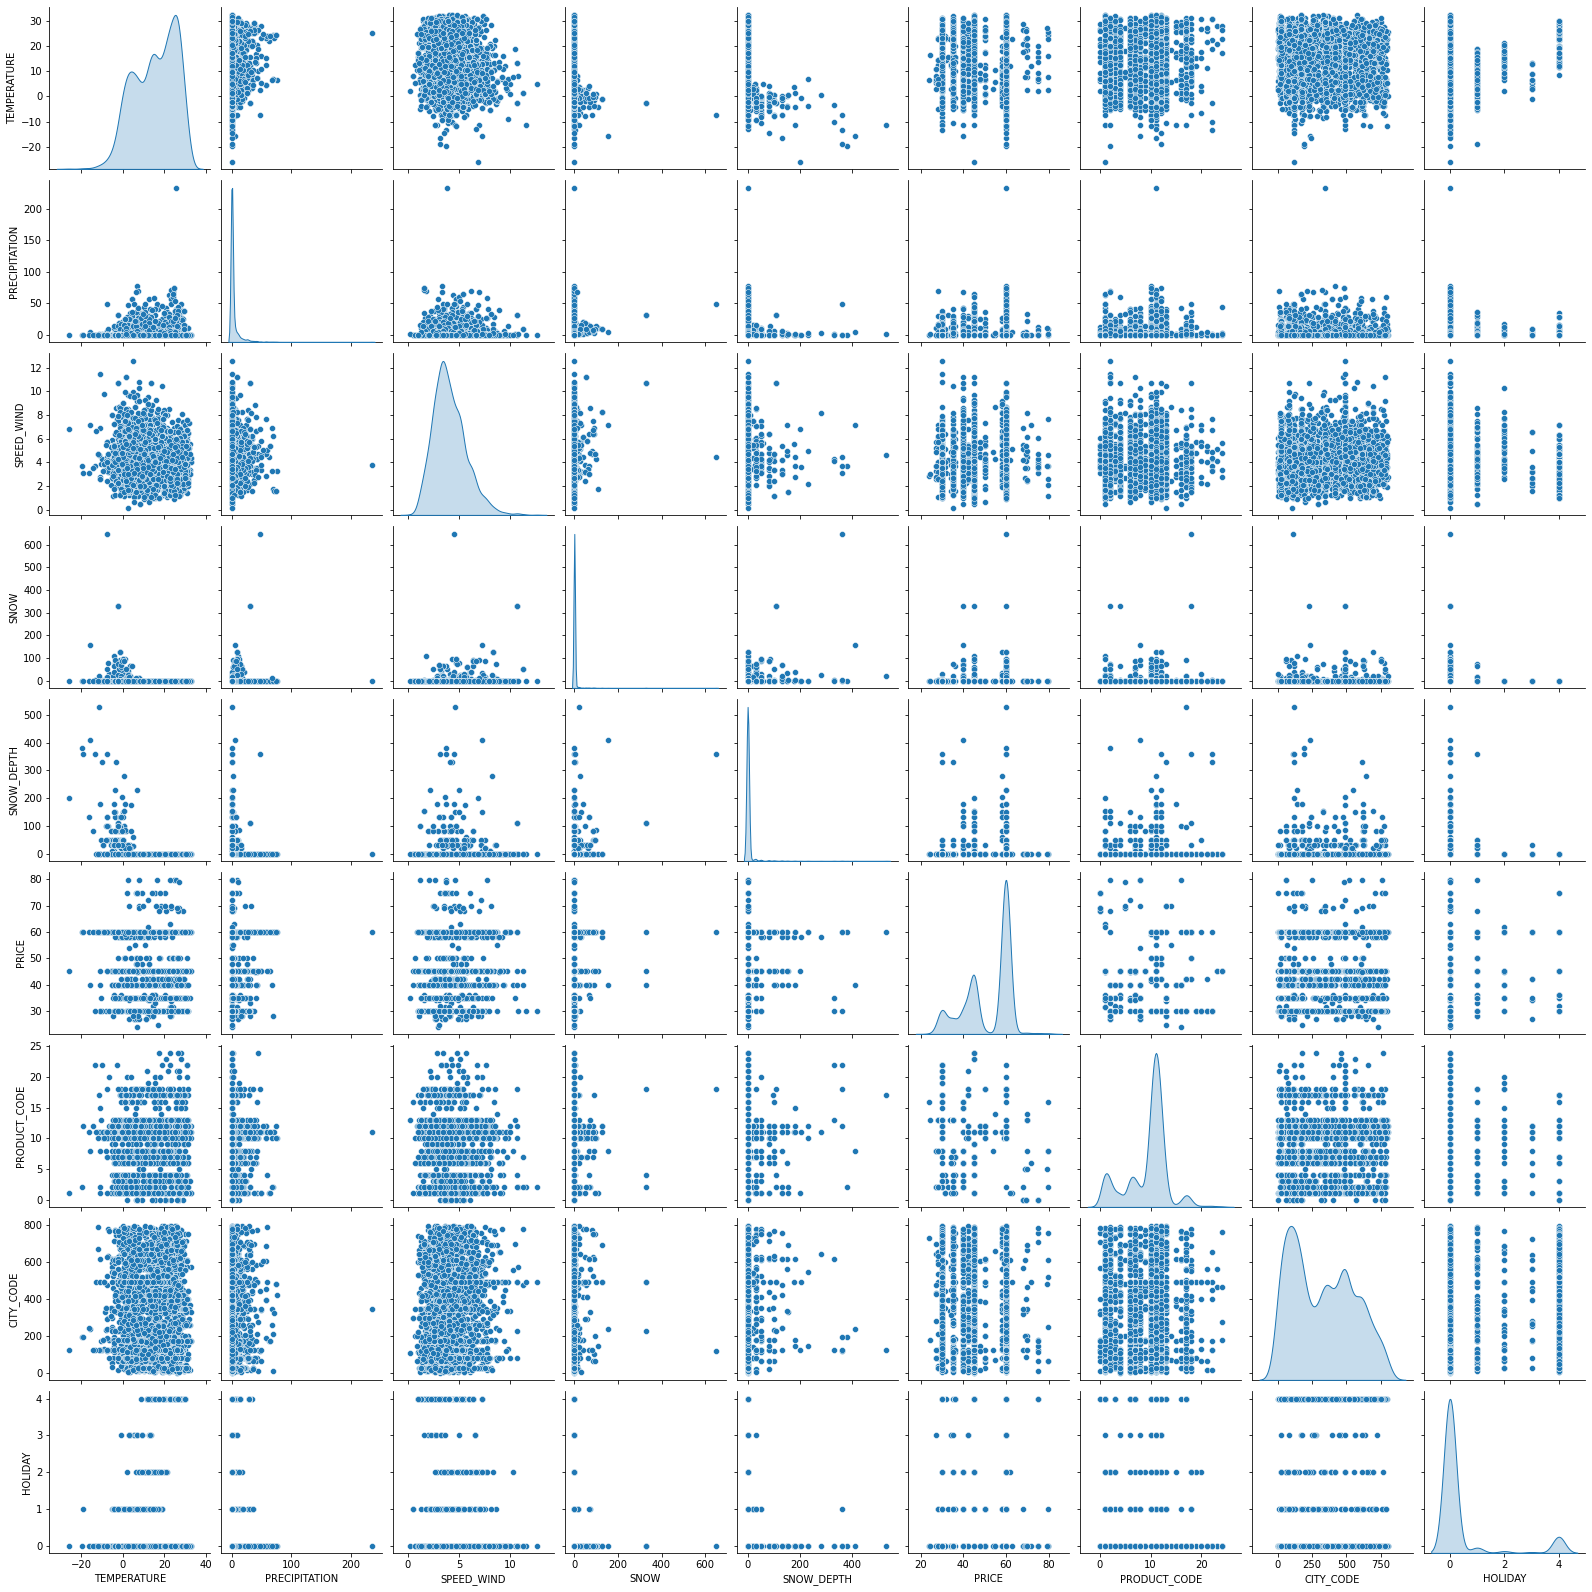

In [16]:
sns.pairplot(train_dataset, diag_kind="kde")

In [17]:
train_stats = train_dataset.describe()
train_stats.pop(var)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TEMPERATURE,3530.0,15.286152,10.081929,-25.9,6.916667,16.2,24.200000,32.6
PRECIPITATION,3530.0,3.176143,9.227422,0.0,0.000000,0.0,1.300000,233.9
SPEED_WIND,3530.0,4.068687,1.623426,0.2,2.933333,3.8,5.033333,12.6
SNOW,3530.0,1.662087,16.974094,0.0,0.000000,0.0,0.000000,650.0
SNOW_DEPTH,3530.0,3.472144,24.660465,0.0,0.000000,0.0,0.000000,530.0
PRODUCT_CODE,3530.0,9.439093,4.028357,0.0,7.000000,11.0,12.000000,24.0
CITY_CODE,3530.0,327.820680,225.042612,0.0,121.000000,334.0,490.000000,799.0
HOLIDAY,3530.0,0.426912,1.175653,0.0,0.000000,0.0,0.000000,4.0


### Excluir el objetivo de los datos

El modelo se encargará de predecir este atributo

In [18]:
train_labels = train_dataset.pop(var)
test_labels = test_dataset.pop(var)

In [19]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
print(normed_train_data)
print(normed_test_data)

      TEMPERATURE  PRECIPITATION  SPEED_WIND      SNOW  SNOW_DEPTH  \
4805    -0.805350       2.509606    2.236821 -0.097919   -0.140798   
4133     0.576660      -0.344207   -0.535095 -0.097919   -0.140798   
2363     1.142028      -0.344207   -1.151077 -0.097919   -0.140798   
4656     0.482432      -0.344207   -1.089478 -0.097919   -0.140798   
2589     0.353489       0.067609    0.696867 -0.097919   -0.140798   
...           ...            ...         ...       ...         ...   
4414     0.199748      -0.344207   -1.890254 -0.097919   -0.140798   
1998     1.429672      -0.344207   -0.843086 -0.097919   -0.140798   
1155     0.507229      -0.344207   -0.227105 -0.097919   -0.140798   
1261     0.973410      -0.344207   -0.391366 -0.097919   -0.140798   
1587     1.474306      -0.344207    0.820064 -0.097919   -0.140798   

      PRODUCT_CODE  CITY_CODE   HOLIDAY  
4805      0.387480  -1.096773 -0.363128  
4133     -1.598442  -0.705736 -0.363128  
2363      0.139240   1.209457 -0.

# Regresión mediante algoritmo Lineal

In [21]:
model_lm = linear_model.LinearRegression()
name = 'LM'

In [22]:
model_lm.fit(normed_train_data, train_labels)
prediccion = model_lm.predict(normed_train_data)

In [23]:
# Nivel de aprendizaje, entre 0 y 1 (0: No ha aprendido nada, 1: Lo ha aprendido a la perfección)
print("Puntuacion: %.2f" % model_lm.score(normed_test_data, test_labels))
# Nivel de varianza, lo mejor es 1
print('R2 Score: %.2f' % r2_score(train_labels, prediccion))
# Error cuadratico medio - RMSE. Representa a la raíz cuadrada de la distancia cuadrada promedio entre el valor real y el valor pronosticado. Los valores más bajos de RMSE indican un mejor ajuste
print("Error cuadratico medio - RMSE: %.2f" % mean_squared_error(train_labels, prediccion, squared = False))

Puntuacion: 0.16
R2 Score: 0.20
Error cuadratico medio - RMSE: 9.72


### Representación gráfica

Se comprueba graficamente la precisión de las predicciones (cuanto más pegado a la línea, más correcto es el valor)

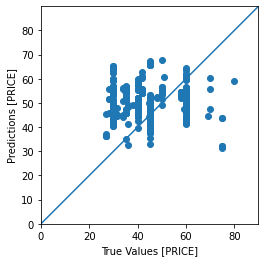

In [24]:
test_predictions = model_lm.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+var+']')
plt.ylabel('Predictions ['+var+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,max(max(test_labels), max(test_predictions))+10])
plt.ylim([0,max(max(test_labels), max(test_predictions))+10])
_ = plt.plot([0, max(max(test_labels), max(test_predictions))+10], [0, max(max(test_labels), max(test_predictions))+10])

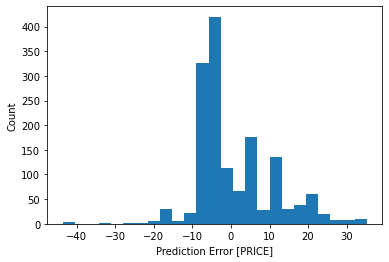

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error ['+var+']')
_ = plt.ylabel("Count")

### Importar datos para predicciones

In [1]:
df_for_predictions = pd.read_excel('for_predictions.xlsx')
df_for_predictions.dropna(inplace=True)
df_for_predictions.replace({"PRODUCT": d_product_v,"CITY": d_city_v},inplace=True)
df_for_predictions.head()

NameError: name 'pd' is not defined

#### Predicción mediante algoritmo lineal

In [27]:
# df_lm = df_for_predictions.copy()
# predictions_lm = model_lm.predict(df_lm)
# df_pred_lm = pd.DataFrame(predictions_lm)
# df_lm['PREDICTIONS'] = df_pred_lm
# df_lm.replace({"PRODUCT": d_product,"CITY": d_city},inplace=True)
# df_lm

# Construcción modelo mediante Redes Neuronales

Se utiliza un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

In [28]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

### Entrenar el modelo
Se entrena el modelo durante 1000 épocas y se registra la precisión de entrenamiento y validación en el objeto history.

In [29]:
EPOCHS = 500
model_rn = build_model()
model_rn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

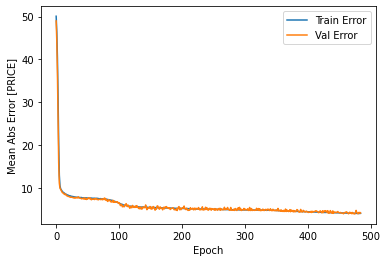

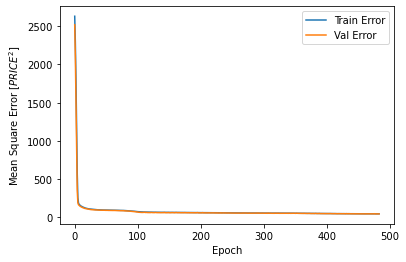

In [30]:
callbacks = []
callbacks.append(PrintDot())

if early_stp is True:
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(early_stop)

if save_model is True:
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)
    callbacks.append(cp_callback)

history = model_rn.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=callbacks)

plot_history(history)

Se comprueban los últimos valores del resultado del entrenamiento

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
479,46.683090,4.097841,46.683090,45.668911,4.004948,45.668911,479
480,46.424145,4.091378,46.424145,45.790623,4.332783,45.790623,480
481,46.743477,4.109565,46.743477,45.639091,4.207710,45.639091,481
482,46.680313,4.088893,46.680313,45.604305,4.344790,45.604305,482
483,46.583405,4.122238,46.583405,45.725033,4.203350,45.725033,483


In [32]:
loss, mae, mse = model_rn.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae)+" "+var)

48/48 - 0s - loss: 47.8316 - mae: 4.2637 - mse: 47.8316
Testing set Mean Abs Error:  4.26 PRICE


### Representación gráfica

Se comprueba graficamente la precisión de las predicciones (cuanto más pegado a la línea, más correcto es el valor)

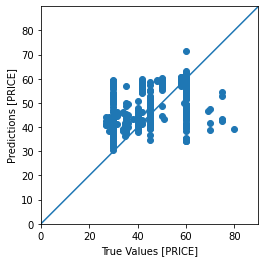

In [33]:
test_predictions = model_rn.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+var+']')
plt.ylabel('Predictions ['+var+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,max(max(test_labels), max(test_predictions))+10])
plt.ylim([0,max(max(test_labels), max(test_predictions))+10])
_ = plt.plot([0, max(max(test_labels), max(test_predictions))+10], [0, max(max(test_labels), max(test_predictions))+10])

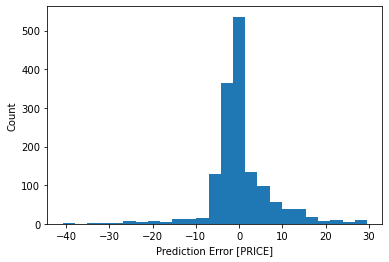

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ["+var+"]")
_ = plt.ylabel("Count")

#### Predicción mediante redes neuronales

In [35]:
df_rn = df_for_predictions.copy()
predictions_rn = model_rn.predict(df_rn)
df_pred_rn = pd.DataFrame(predictions_rn)
df_rn['PREDICTIONS'] = df_pred_rn
df_rn.replace({"PRODUCT": d_product,"CITY": d_city},inplace=True)
df_rn

# Carga del modelo entrenado

In [36]:
if load_model is True:
    # Loads the weights
    model_rn.load_weights(checkpoint_path_trained)

    # Re-evaluate model
    loss, mae, mse = model_rn.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set Mean Abs Error: {:5.2f}".format(mae)+" "+var)